Import Libraries

In [5]:
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Deeplearning Libraries

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Set random seeds for reproducibility

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

Set visualization style

In [8]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*80)
print(" ANIMAL SOUND CLASSIFICATION WITH TRANSFER LEARNING ".center(80, "="))
print("="*80)
print("\n📊 Project Goals:")
print("   • Classify animal sounds: Dog, Cat, Bird")
print("   • Implement baseline 2D CNN on Mel-spectrograms")
print("   • Apply transfer learning with VGGish")
print("   • Apply transfer learning with YAMNet")
print("   • Compare traditional CNN vs. transfer learning")
print("="*80)

============== ANIMAL SOUND CLASSIFICATION WITH TRANSFER LEARNING ==============

📊 Project Goals:
   • Classify animal sounds: Dog, Cat, Bird
   • Implement baseline 2D CNN on Mel-spectrograms
   • Apply transfer learning with VGGish
   • Apply transfer learning with YAMNet
   • Compare traditional CNN vs. transfer learning


CONFIGURATION 

In [9]:
DATASET_PATH = '/kaggle/input/cats-vs-dogs-vs-birds-audio-classification'
SAMPLE_RATE = 16000  # YAMNet and VGGish use 16kHz
DURATION = 3
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512

print(f"\n⚙️  Configuration:")
print(f"   • Sample Rate: {SAMPLE_RATE} Hz (optimized for YAMNet/VGGish)")
print(f"   • Audio Duration: {DURATION} seconds")
print(f"   • Mel Bins: {N_MELS}")


⚙️  Configuration:
   • Sample Rate: 16000 Hz (optimized for YAMNet/VGGish)
   • Audio Duration: 3 seconds
   • Mel Bins: 128


EXPLORE DATASET STRUCTURE

In [11]:
print("\n" + "="*80)
print(" DATASET EXPLORATION ".center(80, "="))
print("="*80)

print(f"\n📁 Exploring dataset structure...")
for item in os.listdir(DATASET_PATH):
    item_path = os.path.join(DATASET_PATH, item)
    if os.path.isdir(item_path):
        print(f"\n  📂 {item}/")
        files = os.listdir(item_path)[:5]
        for f in files:
            print(f"     ├─ {f}")
        if len(os.listdir(item_path)) > 5:
            print(f"     └─ ... and {len(os.listdir(item_path)) - 5} more files")


============================= DATASET EXPLORATION ==============================

📁 Exploring dataset structure...

  📂 Animals/
     ├─ dog
     ├─ bird
     ├─ cat


FEATURE EXTRACTION 

In [12]:
def extract_melspectrogram(file_path, sr=SAMPLE_RATE, duration=DURATION):
    """
    Extract Mel-spectrogram for baseline CNN
    Mel-spectrograms represent audio in time-frequency domain
    """
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
        if len(audio) < sr * duration:
            audio = np.pad(audio, (0, sr * duration - len(audio)))
        
        # Compute mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        return mel_spec_db
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None

def extract_waveform(file_path, sr=SAMPLE_RATE, duration=DURATION):
    """
    Extract raw waveform for transfer learning models
    YAMNet and VGGish process raw audio waveforms
    """
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
        if len(audio) < sr * duration:
            audio = np.pad(audio, (0, sr * duration - len(audio)))
        elif len(audio) > sr * duration:
            audio = audio[:sr * duration]
        
        return audio
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None

LOAD DATA

In [13]:
def load_dataset(dataset_path, feature_type='melspectrogram'):
    """
    Load and extract features from all audio files
    feature_type: 'melspectrogram' for CNN, 'waveform' for transfer learning
    """
    features = []
    labels = []
    
    all_items = os.listdir(dataset_path)
    top_dirs = [item for item in all_items if os.path.isdir(os.path.join(dataset_path, item))]
    
    categories = []
    category_paths = {}
    
    for top_dir in top_dirs:
        top_path = os.path.join(dataset_path, top_dir)
        sub_items = os.listdir(top_path)
        
        audio_files = [f for f in sub_items if f.endswith(('.wav', '.mp3', '.flac'))]
        if audio_files:
            categories.append(top_dir)
            category_paths[top_dir] = top_path
        else:
            sub_dirs = [item for item in sub_items if os.path.isdir(os.path.join(top_path, item))]
            for sub_dir in sub_dirs:
                sub_path = os.path.join(top_path, sub_dir)
                sub_audio = [f for f in os.listdir(sub_path) if f.endswith(('.wav', '.mp3', '.flac'))]
                if sub_audio:
                    categories.append(sub_dir)
                    category_paths[sub_dir] = sub_path
    
    print(f"\n🎯 Found categories: {categories}")
    
    if not categories:
        print("❌ ERROR: No audio files found!")
        return np.array([]), np.array([])
    
    for category in categories:
        category_path = category_paths[category]
        files = [f for f in os.listdir(category_path) if f.endswith(('.wav', '.mp3', '.flac'))]
        
        print(f"\n🔄 Processing {len(files)} files from '{category}'...")
        
        for i, file in enumerate(files):
            file_path = os.path.join(category_path, file)
            
            if feature_type == 'melspectrogram':
                feature = extract_melspectrogram(file_path)
            else:  # waveform
                feature = extract_waveform(file_path)
            
            if feature is not None:
                features.append(feature)
                labels.append(category)
            
            if (i + 1) % 50 == 0:
                print(f"   ✓ Processed {i + 1}/{len(files)} files")
    
    return np.array(features), np.array(labels)

LOAD DATA FOR BASELINE CNN

In [14]:
print("\n" + "="*80)
print(" LOADING DATA FOR BASELINE CNN ".center(80, "="))
print("="*80)

X_mel, y = load_dataset(DATASET_PATH, feature_type='melspectrogram')

if len(X_mel) == 0:
    raise SystemExit("❌ No audio data found!")

print(f"\n✅ Mel-spectrograms loaded!")
print(f"   • Shape: {X_mel.shape}")
print(f"   • Samples: {X_mel.shape[0]}")


======================== LOADING DATA FOR BASELINE CNN =========================

🎯 Found categories: ['dog', 'bird', 'cat']

🔄 Processing 210 files from 'dog'...
   ✓ Processed 50/210 files
   ✓ Processed 100/210 files
   ✓ Processed 150/210 files
   ✓ Processed 200/210 files

🔄 Processing 193 files from 'bird'...
   ✓ Processed 50/193 files
   ✓ Processed 100/193 files
   ✓ Processed 150/193 files

🔄 Processing 207 files from 'cat'...
   ✓ Processed 50/207 files
   ✓ Processed 100/207 files
   ✓ Processed 150/207 files
   ✓ Processed 200/207 files

✅ Mel-spectrograms loaded!
   • Shape: (610, 128, 94)
   • Samples: 610


Display class distribution

In [15]:
print(f"\n📊 Class Distribution:")
for label in np.unique(y):
    count = np.sum(y == label)
    percentage = count/len(y)*100
    bar = '█' * int(percentage/2)
    print(f"   {label:8s}: {count:4d} samples ({percentage:5.1f}%) {bar}")


📊 Class Distribution:
   bird    :  193 samples ( 31.6%) ███████████████
   cat     :  207 samples ( 33.9%) ████████████████
   dog     :  210 samples ( 34.4%) █████████████████


Visualize sample mel-spectrogram

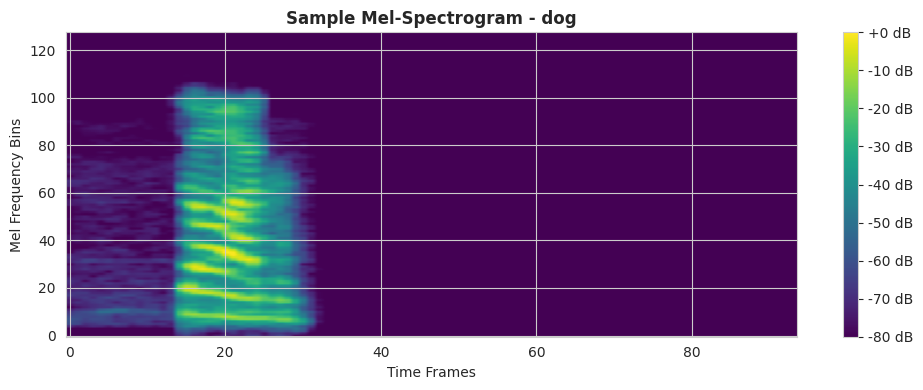

In [16]:
plt.figure(figsize=(10, 4))
plt.imshow(X_mel[0], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Sample Mel-Spectrogram - {y[0]}', fontsize=12, fontweight='bold')
plt.ylabel('Mel Frequency Bins')
plt.xlabel('Time Frames')
plt.tight_layout()
plt.show()

Encode labels

In [17]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = len(le.classes_)

print(f"\n📦 Classes: {le.classes_}")


📦 Classes: ['bird' 'cat' 'dog']


MODEL 1: BASELINE 2D CNN 

In [19]:
print("\n" + "="*80)
print(" MODEL 1: BASELINE 2D CNN ON MEL-SPECTROGRAMS ".center(80, "="))
print("="*80)

# Prepare data for 2D CNN
X_mel_cnn = X_mel[..., np.newaxis]  # Add channel dimension

X_train_mel, X_test_mel, y_train, y_test = train_test_split(
    X_mel_cnn, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n📦 Data Split:")
print(f"   • Training: {X_train_mel.shape}")
print(f"   • Testing: {X_test_mel.shape}")

def build_baseline_cnn(input_shape, num_classes):
    """Baseline 2D CNN for Mel-spectrograms"""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

baseline_cnn = build_baseline_cnn(X_train_mel.shape[1:], num_classes)
baseline_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n🧠 Baseline CNN Architecture:")
baseline_cnn.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1)
]

print("\n🚀 Training Baseline 2D CNN...")
history_cnn = baseline_cnn.fit(
    X_train_mel, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)
# Evaluate
y_pred_cnn = baseline_cnn.predict(X_test_mel, verbose=0)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
acc_cnn = accuracy_score(y_test_classes, y_pred_cnn_classes)

print(f"\n✅ Baseline CNN Test Accuracy: {acc_cnn:.4f} ({acc_cnn*100:.2f}%)")
print("\n📋 Classification Report:")
print(classification_report(y_test_classes, y_pred_cnn_classes, target_names=le.classes_))


================= MODEL 1: BASELINE 2D CNN ON MEL-SPECTROGRAMS =================

📦 Data Split:
   • Training: (488, 128, 94, 1)
   • Testing: (122, 128, 94, 1)

🧠 Baseline CNN Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 92, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 17920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,293,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,386,947 (9.11 MB)

 Trainable params: 2,386,947 (9.11 MB)

 Non-trainable params: 0 (0.00 B)


🚀 Training Baseline 2D CNN...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - accuracy: 0.3541 - loss: 17.3779 - val_accuracy: 0.2959 - val_loss: 1.4226 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - accuracy: 0.3615 - loss: 1.2465 - val_accuracy: 0.3367 - val_loss: 1.0746 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step - accuracy: 0.4102 - loss: 1.0598 - val_accuracy: 0.4694 - val_loss: 1.0112 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.4780 - loss: 1.0801 - val_accuracy: 0.4796 - val_loss: 1.0896 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5497 - loss: 1.0529 - val_accuracy: 0.2959 - val_loss: 1.4868 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5164 - loss: 1.1187 - val_accuracy: 0.7245 - val_loss: 0.8011 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - ac

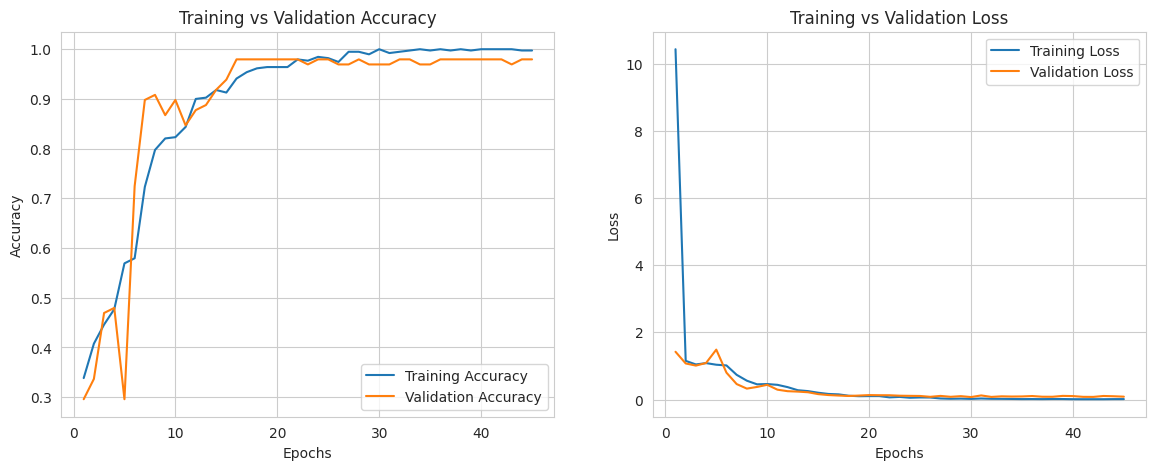

In [20]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

# Call the function
plot_training_curves(history_cnn)


MODEL 2: TRANSFER LEARNING WITH YAMNET

In [21]:
print("\n" + "="*80)
print(" MODEL 2: TRANSFER LEARNING WITH YAMNET ".center(80, "="))
print("="*80)

print("\n🔄 Loading raw waveforms for YAMNet...")
X_wave, _ = load_dataset(DATASET_PATH, feature_type='waveform')

X_train_wave, X_test_wave, y_train_tl, y_test_tl = train_test_split(
    X_wave, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n📦 Waveform Data:")
print(f"   • Training: {X_train_wave.shape}")
print(f"   • Testing: {X_test_wave.shape}")

# Load YAMNet
print("\n📥 Loading pre-trained YAMNet model...")
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

def extract_yamnet_embeddings(waveforms):
    """Extract embeddings from YAMNet for all waveforms"""
    embeddings = []
    print("   Extracting YAMNet embeddings...")
    for i, wav in enumerate(waveforms):
        scores, emb, spectrogram = yamnet_model(wav)
        # Average embeddings across time
        avg_embedding = tf.reduce_mean(emb, axis=0)
        embeddings.append(avg_embedding.numpy())
        if (i + 1) % 50 == 0:
            print(f"   ✓ Processed {i + 1}/{len(waveforms)} samples")
    return np.array(embeddings)

X_train_yamnet = extract_yamnet_embeddings(X_train_wave)
X_test_yamnet = extract_yamnet_embeddings(X_test_wave)

print(f"\n✅ YAMNet embeddings extracted!")
print(f"   • Embedding dimension: {X_train_yamnet.shape[1]}")

# Build classifier on top of YAMNet embeddings
yamnet_classifier = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_yamnet.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

yamnet_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n🚀 Training YAMNet classifier...")
history_yamnet = yamnet_classifier.fit(
    X_train_yamnet, y_train_tl,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
y_pred_yamnet = yamnet_classifier.predict(X_test_yamnet, verbose=0)
y_pred_yamnet_classes = np.argmax(y_pred_yamnet, axis=1)
y_test_tl_classes = np.argmax(y_test_tl, axis=1)
acc_yamnet = accuracy_score(y_test_tl_classes, y_pred_yamnet_classes)

print(f"\n✅ YAMNet Test Accuracy: {acc_yamnet:.4f} ({acc_yamnet*100:.2f}%)")
print("\n📋 Classification Report:")
print(classification_report(y_test_tl_classes, y_pred_yamnet_classes, target_names=le.classes_))



==================== MODEL 2: TRANSFER LEARNING WITH YAMNET ====================

🔄 Loading raw waveforms for YAMNet...

🎯 Found categories: ['dog', 'bird', 'cat']

🔄 Processing 210 files from 'dog'...
   ✓ Processed 50/210 files
   ✓ Processed 100/210 files
   ✓ Processed 150/210 files
   ✓ Processed 200/210 files

🔄 Processing 193 files from 'bird'...
   ✓ Processed 50/193 files
   ✓ Processed 100/193 files
   ✓ Processed 150/193 files

🔄 Processing 207 files from 'cat'...
   ✓ Processed 50/207 files
   ✓ Processed 100/207 files
   ✓ Processed 150/207 files
   ✓ Processed 200/207 files

📦 Waveform Data:
   • Training: (488, 48000)
   • Testing: (122, 48000)

📥 Loading pre-trained YAMNet model...
   Extracting YAMNet embeddings...
   ✓ Processed 50/488 samples
   ✓ Processed 100/488 samples
   ✓ Processed 150/488 samples
   ✓ Processed 200/488 samples
   ✓ Processed 250/488 samples
   ✓ Processed 300/488 samples
   ✓ Processed 350/488 samples
   ✓ Processed 400/488 samples
   ✓ Proce

MODEL 3: TRANSFER LEARNING WITH VGGISH

In [22]:
print("\n" + "="*80)
print(" MODEL 3: TRANSFER LEARNING WITH VGGISH ".center(80, "="))
print("="*80)

# Load VGGish
print("\n📥 Loading pre-trained VGGish model...")
vggish_model = hub.load('https://tfhub.dev/google/vggish/1')

def extract_vggish_embeddings(waveforms):
    """Extract embeddings from VGGish for all waveforms"""
    embeddings = []
    print("   Extracting VGGish embeddings...")
    for i, wav in enumerate(waveforms):
        # VGGish expects input in specific format
        emb = vggish_model(wav)
        # Average embeddings if multiple frames
        if len(emb.shape) > 1:
            avg_embedding = tf.reduce_mean(emb, axis=0)
        else:
            avg_embedding = emb
        embeddings.append(avg_embedding.numpy())
        if (i + 1) % 50 == 0:
            print(f"   ✓ Processed {i + 1}/{len(waveforms)} samples")
    return np.array(embeddings)

X_train_vggish = extract_vggish_embeddings(X_train_wave)
X_test_vggish = extract_vggish_embeddings(X_test_wave)

print(f"\n✅ VGGish embeddings extracted!")
print(f"   • Embedding dimension: {X_train_vggish.shape[1]}")

# Build classifier on top of VGGish embeddings
vggish_classifier = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_vggish.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

vggish_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n🚀 Training VGGish classifier...")
history_vggish = vggish_classifier.fit(
    X_train_vggish, y_train_tl,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
y_pred_vggish = vggish_classifier.predict(X_test_vggish, verbose=0)
y_pred_vggish_classes = np.argmax(y_pred_vggish, axis=1)
acc_vggish = accuracy_score(y_test_tl_classes, y_pred_vggish_classes)

print(f"\n✅ VGGish Test Accuracy: {acc_vggish:.4f} ({acc_vggish*100:.2f}%)")
print("\n📋 Classification Report:")
print(classification_report(y_test_tl_classes, y_pred_vggish_classes, target_names=le.classes_))



==================== MODEL 3: TRANSFER LEARNING WITH VGGISH ====================

📥 Loading pre-trained VGGish model...
   Extracting VGGish embeddings...
   ✓ Processed 50/488 samples
   ✓ Processed 100/488 samples
   ✓ Processed 150/488 samples
   ✓ Processed 200/488 samples
   ✓ Processed 250/488 samples
   ✓ Processed 300/488 samples
   ✓ Processed 350/488 samples
   ✓ Processed 400/488 samples
   ✓ Processed 450/488 samples
   Extracting VGGish embeddings...
   ✓ Processed 50/122 samples
   ✓ Processed 100/122 samples

✅ VGGish embeddings extracted!
   • Embedding dimension: 128

🚀 Training VGGish classifier...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.3291 - loss: 1.4367 - val_accuracy: 0.3367 - val_loss: 1.1072 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4782 - loss: 0.9971 - val_accuracy: 0.3469 - val_loss: 1.1104 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5220 - l


✅ VGGish Test Accuracy: 0.5410 (54.10%)

📋 Classification Report:
              precision    recall  f1-score   support

        bird       0.50      0.69      0.58        39
         cat       0.59      0.63      0.61        41
         dog       0.54      0.31      0.39        42

    accuracy                           0.54       122
   macro avg       0.54      0.55      0.53       122
weighted avg       0.54      0.54      0.53       122



FINAL COMPARISON (Visualization)


=================== FINAL RESULTS: CNN vs TRANSFER LEARNING ====================

🏆 Model Performance Ranking:
 Rank                      Model  Test Accuracy
    1            Baseline 2D CNN       0.942623
    2 VGGish (Transfer Learning)       0.540984
    3 YAMNet (Transfer Learning)       0.336066


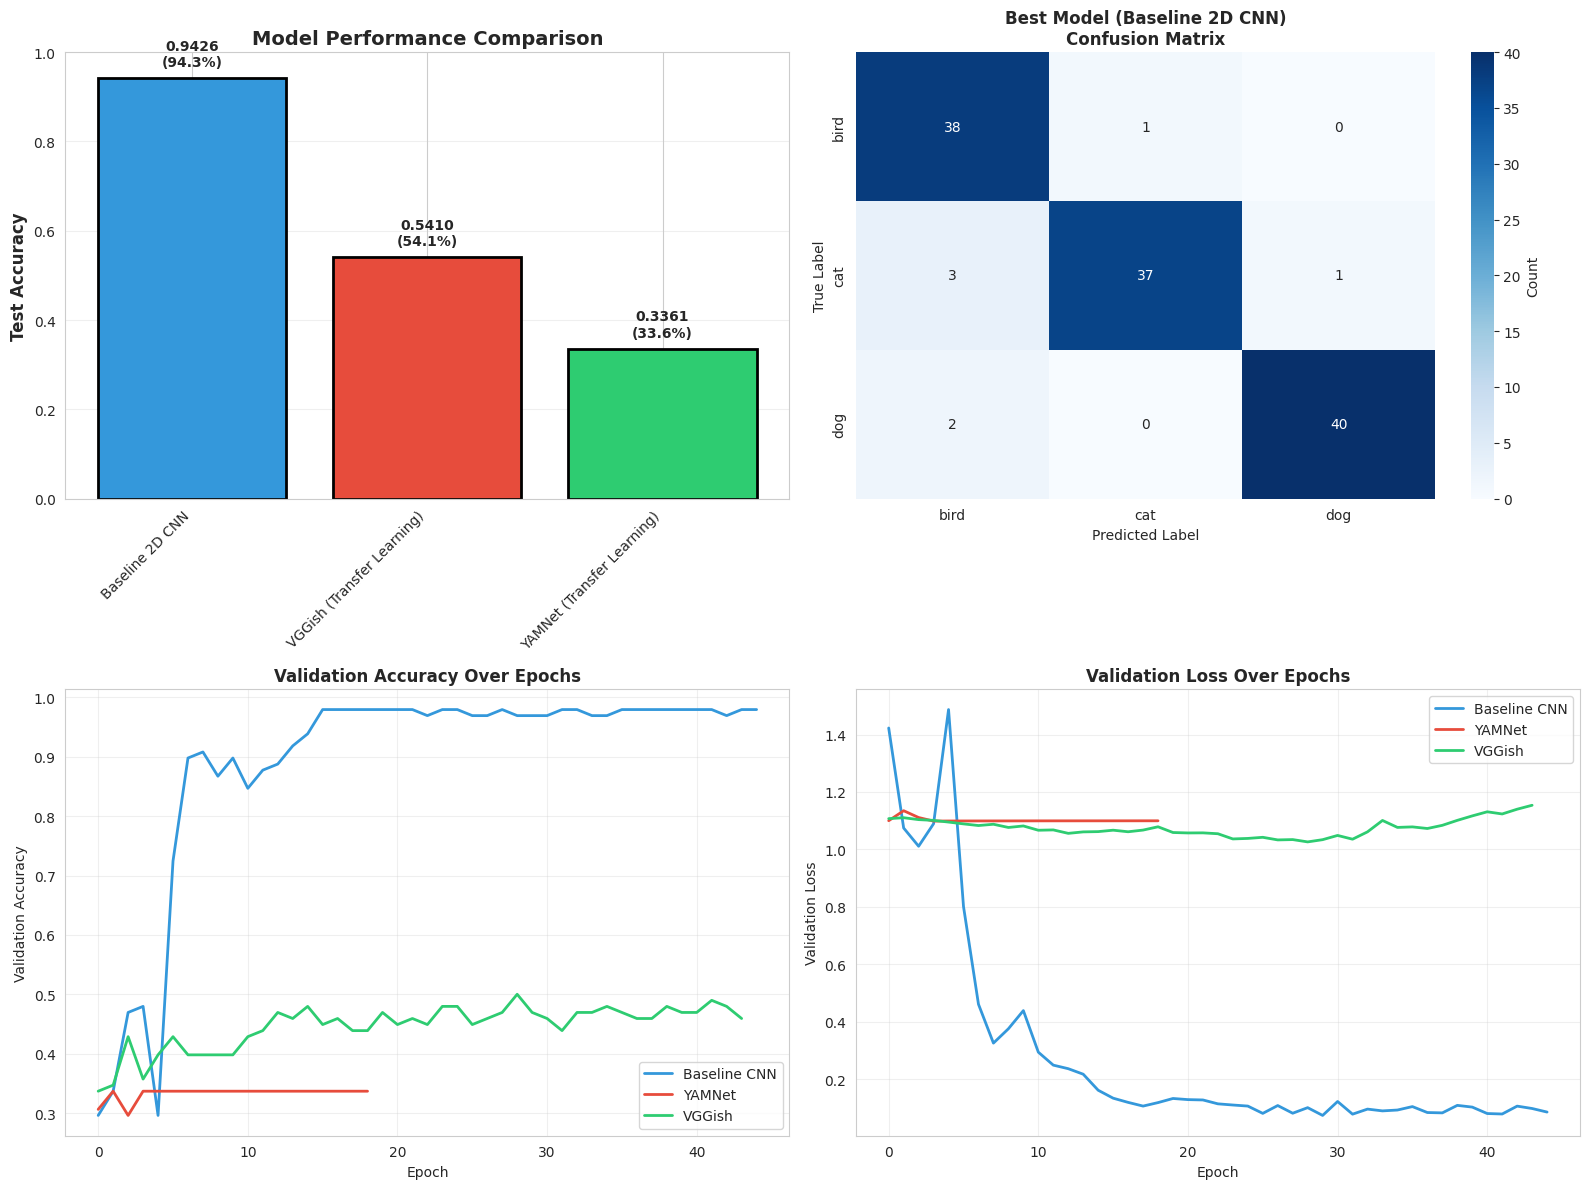

In [24]:
print("\n" + "="*80)
print(" FINAL RESULTS: CNN vs TRANSFER LEARNING ".center(80, "="))
print("="*80)

results = {
    'Baseline 2D CNN': acc_cnn,
    'YAMNet (Transfer Learning)': acc_yamnet,
    'VGGish (Transfer Learning)': acc_vggish
}

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Test Accuracy'])
results_df = results_df.sort_values('Test Accuracy', ascending=False)
results_df['Rank'] = range(1, len(results_df) + 1)
results_df = results_df[['Rank', 'Model', 'Test Accuracy']]

print("\n🏆 Model Performance Ranking:")
print(results_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar chart comparison
ax1 = axes[0, 0]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax1.bar(results_df['Model'], results_df['Test Accuracy'], 
               color=colors, edgecolor='black', linewidth=2)
ax1.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
for bar, acc in zip(bars, results_df['Test Accuracy']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{acc:.4f}\n({acc*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')

# 2. Confusion Matrix - Best Model
ax2 = axes[0, 1]
best_model = results_df.iloc[0]['Model']
if 'YAMNet' in best_model:
    cm = confusion_matrix(y_test_tl_classes, y_pred_yamnet_classes)
elif 'VGGish' in best_model:
    cm = confusion_matrix(y_test_tl_classes, y_pred_vggish_classes)
else:
    cm = confusion_matrix(y_test_classes, y_pred_cnn_classes)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            ax=ax2, cbar_kws={'label': 'Count'})
ax2.set_title(f'Best Model ({best_model})\nConfusion Matrix', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. Training history comparison - Accuracy
ax3 = axes[1, 0]
ax3.plot(history_cnn.history['val_accuracy'], label='Baseline CNN', linewidth=2, color='#3498db')
ax3.plot(history_yamnet.history['val_accuracy'], label='YAMNet', linewidth=2, color='#e74c3c')
ax3.plot(history_vggish.history['val_accuracy'], label='VGGish', linewidth=2, color='#2ecc71')
ax3.set_title('Validation Accuracy Over Epochs', fontsize=12, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Validation Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Training history comparison - Loss
ax4 = axes[1, 1]
ax4.plot(history_cnn.history['val_loss'], label='Baseline CNN', linewidth=2, color='#3498db')
ax4.plot(history_yamnet.history['val_loss'], label='YAMNet', linewidth=2, color='#e74c3c')
ax4.plot(history_vggish.history['val_loss'], label='VGGish', linewidth=2, color='#2ecc71')
ax4.set_title('Validation Loss Over Epochs', fontsize=12, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Validation Loss')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


> The Baseline 2D CNN clearly outperforms both transfer learning models, achieving the highest accuracy and most stable validation curves.
VGGish and YAMNet underperform because their pretrained audio embeddings do not align well with the small 3-class dog–cat–bird dataset, while the CNN learns task-specific features directly from Mel-spectrograms.> 

Summary

In [25]:
print("\n📈 Key Findings:")
print(f"   • Best Model: {results_df.iloc[0]['Model']}")
print(f"   • Best Accuracy: {results_df.iloc[0]['Test Accuracy']:.4f} ({results_df.iloc[0]['Test Accuracy']*100:.2f}%)")
print(f"   • Improvement over baseline: {(results_df.iloc[0]['Test Accuracy'] - acc_cnn)*100:.2f}%")
print(f"\n💡 Transfer learning {'outperforms' if results_df.iloc[0]['Test Accuracy'] > acc_cnn else 'performs similarly to'} baseline CNN")

print("\n" + "="*80)
print(" PROJECT COMPLETE ".center(80, "="))
print("="*80)


📈 Key Findings:
   • Best Model: Baseline 2D CNN
   • Best Accuracy: 0.9426 (94.26%)
   • Improvement over baseline: 0.00%

💡 Transfer learning performs similarly to baseline CNN

=============================== PROJECT COMPLETE ===============================
